**Libraries Importing:**

In [ ]:
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor , StackingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot

**1. Exploratory Data Analysis (EDA) :**

**1.1 Historical Wildfires:**

In [3]:
Historical_wildfires = pd.read_csv('Historical_Wildfires.csv')
Historical_wildfires.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [4]:
Historical_wildfires.shape

(26406, 10)

In [5]:
Historical_wildfires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406 entries, 0 to 26405
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Region                               26406 non-null  object 
 1   Date                                 26406 non-null  object 
 2   Estimated_fire_area                  26406 non-null  float64
 3   Mean_estimated_fire_brightness       26406 non-null  float64
 4   Mean_estimated_fire_radiative_power  26406 non-null  float64
 5   Mean_confidence                      26406 non-null  float64
 6   Std_confidence                       24199 non-null  float64
 7   Var_confidence                       24199 non-null  float64
 8   Count                                26406 non-null  int64  
 9   Replaced                             26406 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.0+ MB


In [6]:
Historical_wildfires.describe()

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count
count,26406.000000,26406.000000,26406.000000,26406.000000,24199.000000,24199.000000,26406.000000
mean,144.297966,319.662078,83.621258,87.574735,7.228302,56.229092,72.059305
std,314.453847,8.862005,67.510022,4.371972,1.995221,25.898935,150.973128
min,1.000000,290.700000,0.000000,76.000000,0.000000,0.000000,1.000000
25%,8.911875,313.933333,44.150391,85.000000,6.687010,44.716106,5.000000
50%,38.434091,319.784412,67.133333,87.771429,7.707025,59.398234,20.000000
75%,146.951278,325.403144,103.123611,90.498403,8.236665,67.842642,74.000000
max,10120.943170,381.950000,2178.600000,100.000000,16.970563,288.000000,3954.000000


In [7]:
Historical_wildfires.isnull().sum()

Region                                    0
Date                                      0
Estimated_fire_area                       0
Mean_estimated_fire_brightness            0
Mean_estimated_fire_radiative_power       0
Mean_confidence                           0
Std_confidence                         2207
Var_confidence                         2207
Count                                     0
Replaced                                  0
dtype: int64

**1.1.1 dropping null values:**

we deopped here the columns that have null values rather than dropping the records of null values because we do not want to lose data samples and these columns are not too much important at the same time.

In [8]:
Historical_wildfires.drop(['Std_confidence','Var_confidence'], axis=1 ,inplace= True)
Historical_wildfires.isnull().sum()

Region                                 0
Date                                   0
Estimated_fire_area                    0
Mean_estimated_fire_brightness         0
Mean_estimated_fire_radiative_power    0
Mean_confidence                        0
Count                                  0
Replaced                               0
dtype: int64

In [9]:
Historical_wildfires.Region.value_counts()    # Fire entries count in each region

WA     5627
QL     5533
NT     5053
NSW    4623
VI     2176
SA     1990
TA     1404
Name: Region, dtype: int64

**1.1.2 Outliers Handling:**

In [10]:
fig = px.box(Historical_wildfires,x='Estimated_fire_area',color='Region')
fig.show()

**finding outliers with Interquartile Range (IQR) method:**

In [11]:
Q1=Historical_wildfires['Estimated_fire_area'].quantile(0.25)
Q3=Historical_wildfires['Estimated_fire_area'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1-(1.5*IQR)
Upper_Whisker = Q3+(1.5*IQR)
print(Lower_Whisker, Upper_Whisker)

8.911875
146.95127755
138.03940254999998
-198.14722882499996 354.01038137499995


IQR method calculated an upper whisker of  approximately 354. However, an upper_whisker is chosen equal to a fire-estimated_area of 4000 depending on data visualization in the boxplot to maintain the variety of data samples.

In [12]:
Historical_wildfires = Historical_wildfires[Historical_wildfires['Estimated_fire_area']< 4000]
Historical_wildfires.shape

(26389, 8)

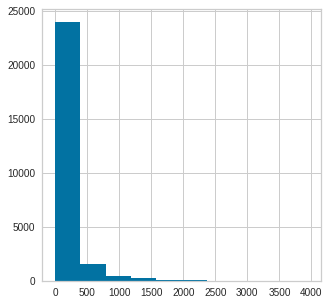

In [13]:
Historical_wildfires.Estimated_fire_area.hist(figsize=(5,5))

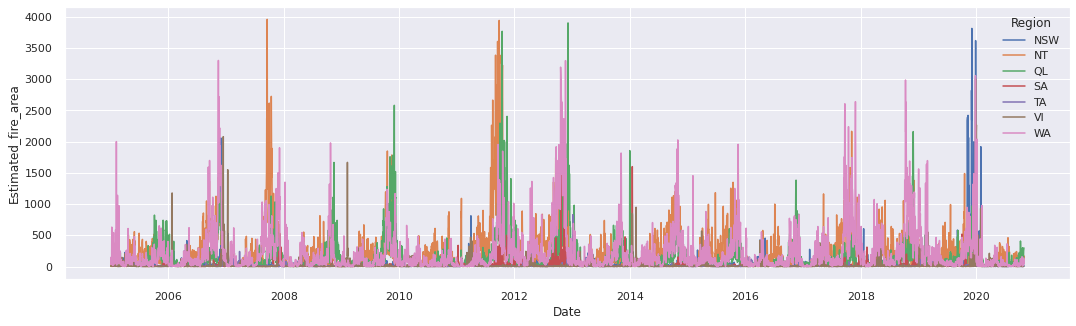

In [14]:
Historical_wildfires['Date'] = pd.to_datetime(Historical_wildfires['Date'])
plt.figure(figsize=(18, 5))
sns.set(style='darkgrid')
g = sns.lineplot(x='Date', y='Estimated_fire_area',hue='Region', data=Historical_wildfires)

**1.2 Historical Weather:**

In [15]:
Historical_Weather= pd.read_csv('HistoricalWeather.csv')
Historical_Weather['Date'] = pd.to_datetime(Historical_Weather['Date'])
Historical_Weather = Historical_Weather.rename(columns={"count()[unit: km^2]": "Area in km2"})
Historical_Weather.head()

,Date,Region,Parameter,Area in km2,min(),max(),mean(),variance()
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [16]:
Historical_Weather.shape

(242781, 8)

In [17]:
Historical_Weather.isna().sum()

Date           0
Region         0
Parameter      0
Area in km2    0
min()          0
max()          0
mean()         0
variance()     0
dtype: int64

In [18]:
Historical_Weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242781 entries, 0 to 242780
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         242781 non-null  datetime64[ns]
 1   Region       242781 non-null  object        
 2   Parameter    242781 non-null  object        
 3   Area in km2  242781 non-null  float64       
 4   min()        242781 non-null  float64       
 5   max()        242781 non-null  float64       
 6   mean()       242781 non-null  float64       
 7   variance()   242781 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 14.8+ MB


In [19]:
A1= Historical_Weather['Region'].unique()          # presenting spaces of concerned regions
A2= Historical_Weather['Area in km2'].unique()

for region,area in zip(A1,A2):
  print(region + "'s" ,'area is equal to:', area, 'km2')

NSW's area is equal to: 800234.3489860408 km2
NT's area is equal to: 1357560.8702305616 km2
QL's area is equal to: 1730605.042927805 km2
SA's area is equal to: 991315.104984634 km2
TA's area is equal to: 67785.26140857418 km2
VI's area is equal to: 229453.1768543154 km2
WA's area is equal to: 2528545.6593604805 km2


**1.2.1 reformatting the data:**

In [20]:
Historical_Weather_pivot = Historical_Weather.pivot_table(values=['min()','max()','mean()','variance()'], index=['Date','Region'],
                                  columns=['Parameter'])
Historical_Weather_pivot.reset_index(inplace=True)

Historical_Weather_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in Historical_Weather_pivot.columns.values]

parameters = Historical_Weather_pivot.columns.tolist()[3:]
parameters.sort()
Weather_Data = Historical_Weather_pivot[Historical_Weather_pivot.columns.tolist()[:3] + parameters].copy()
Weather_Data.head()

,Date,Region,Precipitation_max(),Precipitation_mean(),Precipitation_min(),Precipitation_variance(),RelativeHumidity_max(),RelativeHumidity_mean(),RelativeHumidity_min(),RelativeHumidity_variance(),...,SolarRadiation_min(),SolarRadiation_variance(),Temperature_max(),Temperature_mean(),Temperature_min(),Temperature_variance(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_min(),WindSpeed_variance()
0,2005-01-01,NSW,1.836935,0.044274,0.000000,0.028362,80.522964,36.355567,13.877194,253.559937,...,14.515009,6.078587,35.878704,27.341182,14.485785,18.562212,7.670482,3.323550,1.354448,0.850048
1,2005-01-01,NT,315.266815,9.884958,0.000000,546.059262,95.683342,61.494675,14.558820,584.201131,...,2.518120,58.942658,38.136787,29.881492,24.179960,12.920252,9.704402,5.296892,1.840394,1.930014
2,2005-01-01,QL,74.452164,1.453053,0.000000,35.641257,95.898270,47.959364,14.443199,403.134377,...,6.033827,29.500832,37.047943,28.842866,20.951620,13.792599,7.675632,3.483753,1.106028,0.883048
3,2005-01-01,SA,3.193624,0.059078,0.000000,0.042837,81.980751,30.057683,10.618136,246.044713,...,17.861103,7.914246,38.326847,30.793675,14.095855,34.799336,10.044715,4.657538,2.023657,1.655908
4,2005-01-01,TA,13.604791,3.099497,0.003973,12.068597,81.501442,65.086764,43.906574,111.754034,...,20.742302,12.826400,16.228510,11.788805,6.686816,4.912013,11.432408,5.408138,1.995647,2.963118


In [21]:
Weather_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         40481 non-null  datetime64[ns]
 1   Region                       40481 non-null  object        
 2   Precipitation_max()          40474 non-null  float64       
 3   Precipitation_mean()         40474 non-null  float64       
 4   Precipitation_min()          40474 non-null  float64       
 5   Precipitation_variance()     40474 non-null  float64       
 6   RelativeHumidity_max()       40439 non-null  float64       
 7   RelativeHumidity_mean()      40439 non-null  float64       
 8   RelativeHumidity_min()       40439 non-null  float64       
 9   RelativeHumidity_variance()  40439 non-null  float64       
 10  SoilWaterContent_max()       40481 non-null  float64       
 11  SoilWaterContent_mean()      40481 non-nu

**1.3 Historical Vegetation**

In [22]:
Historical_Vegetation = pd.read_csv('VegetationIndex.csv')
Historical_Vegetation['Date'] = pd.to_datetime(Historical_Vegetation['Date'])
Historical_Vegetation.head()

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,2005-01-01,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2005-02-01,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,2005-03-01,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,2005-04-01,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,2005-05-01,0.345526,0.9972,-0.2,0.202858,0.041151


In [23]:
Historical_Vegetation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Region                     1330 non-null   object        
 1   Date                       1330 non-null   datetime64[ns]
 2   Vegetation_index_mean      1330 non-null   float64       
 3   Vegetation_index_max       1330 non-null   float64       
 4   Vegetation_index_min       1330 non-null   float64       
 5   Vegetation_index_std       1330 non-null   float64       
 6   Vegetation_index_variance  1330 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 72.9+ KB


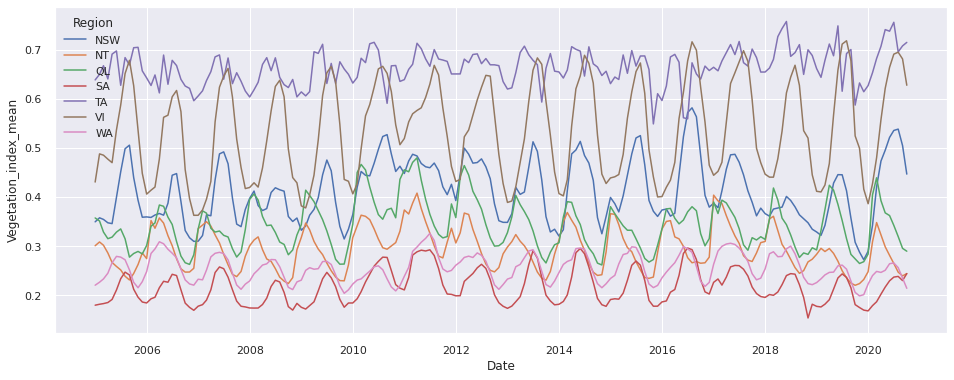

In [24]:
plt.figure(figsize=(16, 6))
sns.set(style='darkgrid')
g = sns.lineplot(x='Date', y='Vegetation_index_mean', hue='Region' ,data=Historical_Vegetation)

**1.4  Land Class**

In [25]:
Land_Class = pd.read_csv('LandClass.csv')
Land_Class

,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0
5,WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8
6,VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9


In [26]:
Land_Class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 15 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Region                                                    7 non-null      object 
 1   Shrubs                                                    7 non-null      float64
 2   Herbaceous vegetation                                     7 non-null      float64
 3   Cultivated and managed vegetation/agriculture (cropland)  7 non-null      float64
 4   Urban / built up                                          7 non-null      float64
 5   Bare / sparse vegetation                                  7 non-null      float64
 6   Permanent water bodies                                    7 non-null      float64
 7   Herbaceous wetland                                        7 non-null      float64
 8   Closed forest, evergreen

**1.5 Data Distributions**

 - Estimated fire area values distribution:

<Figure size 1440x1440 with 0 Axes>

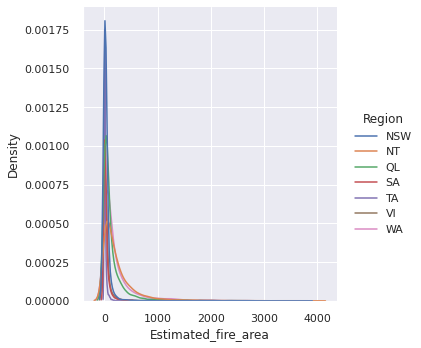

In [27]:
plt.figure(figsize=(20, 20));
sns.set(style="darkgrid")
g = sns.displot(data= Historical_wildfires, kind= 'kde', x="Estimated_fire_area", hue="Region");

- Mean temperature values distribution:

<Figure size 1440x1440 with 0 Axes>

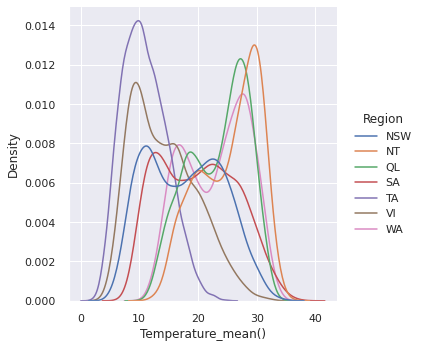

In [28]:
plt.figure(figsize=(20, 20));
sns.set(style="darkgrid")
g = sns.displot(data= Weather_Data, kind= 'kde', x="Temperature_mean()", hue="Region");

- Mean precipitation values distribution:

<Figure size 1440x1440 with 0 Axes>

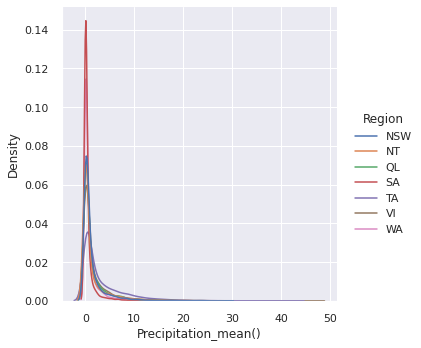

In [29]:
plt.figure(figsize=(20, 20));
sns.set(style="darkgrid")
g = sns.displot(data=Weather_Data, kind= 'kde', x="Precipitation_mean()", hue="Region");

**2. Data Correlations:**

In [30]:
Historical_wildfire_and_Weather = Historical_wildfires.merge(Weather_Data,how='inner', on=['Date', 'Region'])
Historical_wildfire_and_Weather.shape

(26389, 32)

- correlations between weather parameters and estimated wildfires areas:

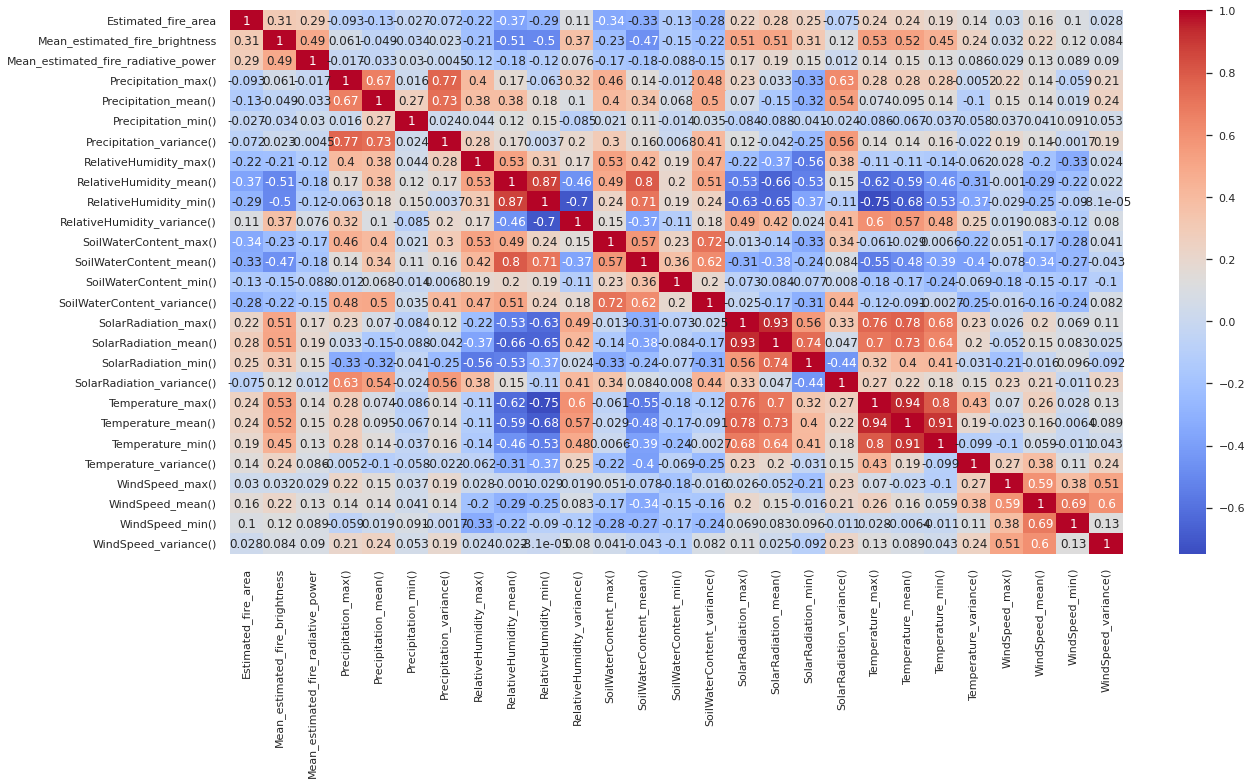

In [31]:
weather_and_fires_corr = Historical_wildfire_and_Weather.drop(['Region', 'Date', 'Mean_confidence','Count', 'Replaced'], axis=1).copy()
plt.figure(figsize = (20, 10))
sns.heatmap(weather_and_fires_corr.corr(), cmap = "coolwarm", annot= True);

- linear relationship between mean temperatures and estimated fire areas:

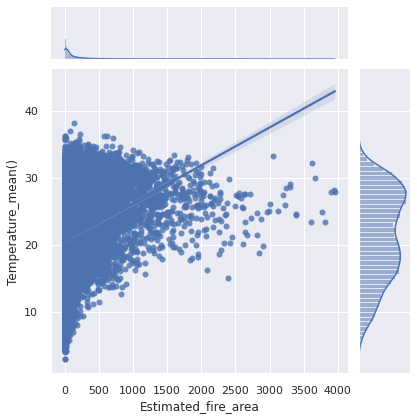

In [32]:
sns.jointplot(x='Estimated_fire_area', y='Temperature_mean()', data= Historical_wildfire_and_Weather, kind= 'reg');

- relationships between max wind speeds and estimated fire areas for each region:

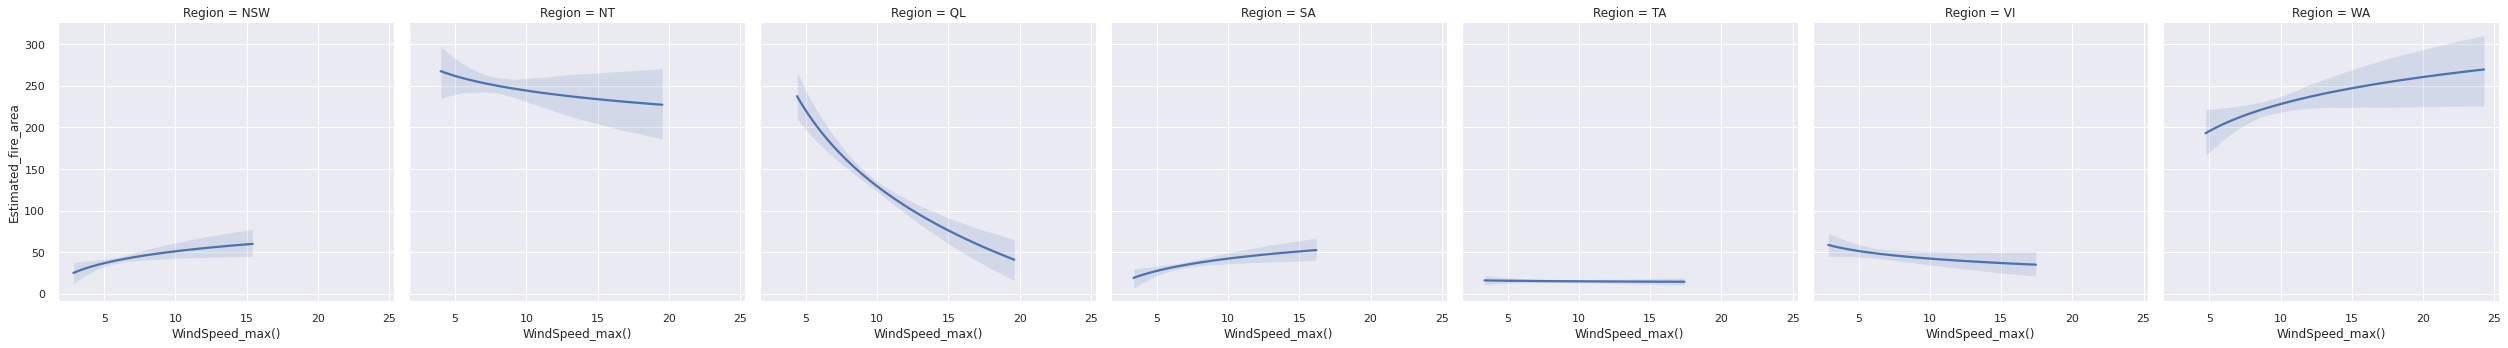

In [33]:
sns.lmplot(x='WindSpeed_max()', y='Estimated_fire_area',data= Historical_wildfire_and_Weather, fit_reg= True, scatter=False, logx=True, col='Region');

- relationship between relative humidity means and estimated fire areas:

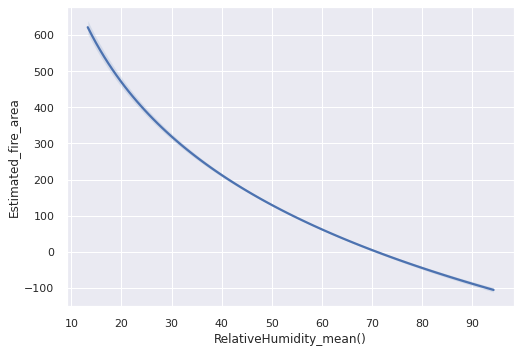

In [34]:
sns.regplot(x='RelativeHumidity_mean()', y='Estimated_fire_area',  data= Historical_wildfire_and_Weather, logx=True, scatter= False)

**3. Preparing Training Data**

**3.1 converting historical vegetation from monthly to daily data:**

this is applied to make the date compatible in all datasets so we can merge the data on date and region.

In [35]:
r = {'NSW','NT','SA','QL','TA','VI','WA'}
for i in r:
  

      globals()['V_'+i] = Historical_Vegetation[Historical_Vegetation['Region']== i].copy()
      globals()['V_'+i] = globals()['V_'+i].pivot_table(values=['Vegetation_index_mean','Vegetation_index_max','Vegetation_index_min','Vegetation_index_std','Vegetation_index_variance','Region'], index=['Date']
                                  )

      start_date = globals()['V_'+i].index.min() - pd.DateOffset(day=1)
      end_date = globals()['V_'+i].index.max() + pd.DateOffset(day=31)

      dates = pd.date_range(start_date, end_date, freq='D')
      dates.name = 'Date'
      globals()['V_'+i] = globals()['V_'+i].reindex(dates, method='ffill')

      globals()['V_'+i].reset_index(inplace= True)

      globals()['V_'+i]= globals()['V_'+i].assign(Region= i)


- Data Merging:

In [36]:
Historical_Vegetation = pd.concat([V_NSW, V_NT, V_QL, V_SA, V_TA, V_VI, V_WA])

wildfires_Weather_Vegetation = Historical_wildfire_and_Weather.merge(Historical_Vegetation,how='left', on=['Date','Region'])

W_W_V_L = wildfires_Weather_Vegetation.merge(Land_Class,how='left', on=['Region'])
W_W_V_L.shape

(26389, 51)

In [37]:
W_W_V_L.isna().sum()

Region                                                       0
Date                                                         0
Estimated_fire_area                                          0
Mean_estimated_fire_brightness                               0
Mean_estimated_fire_radiative_power                          0
Mean_confidence                                              0
Count                                                        0
Replaced                                                     0
Precipitation_max()                                          4
Precipitation_mean()                                         4
Precipitation_min()                                          4
Precipitation_variance()                                     4
RelativeHumidity_max()                                      27
RelativeHumidity_mean()                                     27
RelativeHumidity_min()                                      27
RelativeHumidity_variance()                            

- Removing null values and non important columns from training data:

In [38]:
W_W_V_L = W_W_V_L.drop(['Region','Date','Mean_confidence',
                            'Count', 'Replaced','Mean_estimated_fire_brightness','Mean_estimated_fire_radiative_power'], axis=1).dropna()

- Correlation map of training variables:

In [39]:
W_W_V_L.corr().style.background_gradient(cmap='coolwarm')

,Estimated_fire_area,Precipitation_max(),Precipitation_mean(),Precipitation_min(),Precipitation_variance(),RelativeHumidity_max(),RelativeHumidity_mean(),RelativeHumidity_min(),RelativeHumidity_variance(),SoilWaterContent_max(),SoilWaterContent_mean(),SoilWaterContent_min(),SoilWaterContent_variance(),SolarRadiation_max(),SolarRadiation_mean(),SolarRadiation_min(),SolarRadiation_variance(),Temperature_max(),Temperature_mean(),Temperature_min(),Temperature_variance(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_min(),WindSpeed_variance(),Vegetation_index_max,Vegetation_index_mean,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
Estimated_fire_area,1.000000,-0.092956,-0.130886,-0.026872,-0.071816,-0.216344,-0.372381,-0.290099,0.105687,-0.342501,-0.326963,-0.134508,-0.283117,0.223590,0.275806,0.251463,-0.074718,0.243464,0.239454,0.194658,0.143464,0.030363,0.156514,0.101510,0.027925,0.080990,-0.274763,-0.030955,-0.350046,-0.340638,0.216958,0.122499,-0.187815,-0.198841,-0.047649,-0.160648,-0.139474,-0.214782,0.040916,-0.163805,-0.145734,0.206504,0.094228,-0.048587
Precipitation_max(),-0.092956,1.000000,0.665389,0.016067,0.765056,0.400741,0.167513,-0.062834,0.324469,0.459709,0.139332,-0.011997,0.481222,0.227374,0.032849,-0.328747,0.628906,0.279275,0.279154,0.276884,-0.005023,0.217579,0.142198,-0.059176,0.210084,0.112499,-0.061682,-0.054328,-0.002916,-0.020300,0.073320,0.070496,-0.137334,-0.140942,-0.027951,-0.165414,-0.141764,-0.139409,0.169979,-0.060555,-0.124477,0.161723,0.198048,-0.101200
Precipitation_mean(),-0.130886,0.665389,1.000000,0.267037,0.726901,0.382862,0.380205,0.176221,0.103830,0.404215,0.338827,0.068189,0.498840,0.069719,-0.150627,-0.317527,0.536667,0.074195,0.094683,0.140922,-0.102529,0.148308,0.139975,0.018700,0.243807,0.070631,0.126278,-0.052800,0.101992,0.091549,-0.086623,-0.080710,-0.031214,0.007773,-0.071144,-0.003031,0.059725,0.073410,0.077990,0.097575,0.068770,0.042023,0.071201,0.039024
Precipitation_min(),-0.026872,0.016067,0.267037,1.000000,0.023580,0.043997,0.118624,0.146944,-0.084684,0.020808,0.108997,-0.014130,0.035205,-0.083735,-0.087830,-0.040958,-0.023966,-0.085556,-0.067347,-0.037508,-0.057799,0.037491,0.040981,0.090654,0.053427,-0.012699,0.130823,0.001939,0.056472,0.059432,-0.078016,-0.144852,0.018292,0.060059,-0.041454,0.131316,0.165450,0.153838,-0.063407,0.151895,0.166588,-0.064146,-0.071168,0.153867
Precipitation_variance(),-0.071816,0.765056,0.726901,0.023580,1.000000,0.275710,0.167849,0.003692,0.200240,0.296290,0.158352,0.006901,0.405929,0.123484,-0.042253,-0.247798,0.561088,0.142513,0.140331,0.157216,-0.022205,0.187350,0.138037,-0.001474,0.194822,0.064874,-0.008528,-0.035447,0.013897,0.004773,0.012046,0.031162,-0.071086,-0.060586,-0.013495,-0.076438,-0.057289,-0.055846,0.099161,-0.018984,-0.050147,0.089552,0.097883,-0.046654
RelativeHumidity_max(),-0.216344,0.400741,0.382862,0.043997,0.275710,1.000000,0.526926,0.308895,0.173330,0.527312,0.416095,0.185452,0.466752,-0.216440,-0.371818,-0.563348,0.380665,-0.113050,-0.114860,-0.136573,-0.061315,0.028251,-0.197409,-0.331892,0.023546,0.086457,0.250872,-0.056321,0.323778,0.304232,-0.160395,-0.178865,0.101018,0.072544,-0.157373,-0.084112,-0.008217,0.127468,0.151877,0.175977,0.041642,-0.067940,0.226878,-0.050058
RelativeHumidity_mean(),-0.372381,0.167513,0.380205,0.118624,0.167849,0.526926,1.000000,0.873523,-0.458400,0.487526,0.798463,0.201507,0.508352,-0.534644,-0.659702,-0.530917,0.146743,-0.620554,-0.589000,-0.460866,-0.309985,-0.000925,-0.293362,-0.221008,0.022307,0.037825,0.738233,-0.095171,0.569299,0.558748,-0.499918,-0.553060,0.317158,0.432603,-0.2

In [40]:
X = W_W_V_L.drop(['Estimated_fire_area'], axis=1).copy()  # predictors variables

target = ['Estimated_fire_area']
Y = W_W_V_L[target].values        # target variables

Y = np.ravel(Y)  # reshape Y

**4. Features Selection:**

In [41]:
select = SelectKBest(score_func=f_regression, k=29)
s = select.fit_transform(X, Y)

best_variables = X.columns.values[select.get_support()]
X = X[best_variables]
print(best_variables)

['Precipitation_mean()' 'RelativeHumidity_max()' 'RelativeHumidity_mean()'
 'RelativeHumidity_min()' 'SoilWaterContent_max()'
 'SoilWaterContent_mean()' 'SoilWaterContent_min()'
 'SoilWaterContent_variance()' 'SolarRadiation_max()'
 'SolarRadiation_mean()' 'SolarRadiation_min()' 'Temperature_max()'
 'Temperature_mean()' 'Temperature_min()' 'Temperature_variance()'
 'WindSpeed_mean()' 'Vegetation_index_mean' 'Vegetation_index_std'
 'Vegetation_index_variance' 'Shrubs' 'Herbaceous vegetation'
 'Cultivated and managed vegetation/agriculture (cropland)'
 'Urban / built up' 'Permanent water bodies' 'Herbaceous wetland'
 'Closed forest, evergreen, broad leaf' 'Closed forest, unknown'
 'Open forest, evergreen broad leaf' 'Open forest, deciduous broad leaf']


**5. Data Clustering :**

- choosing optimal number of clusters with elbow method:

In [42]:
distortions = []
K = range(1,20)
for i in K:
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)       

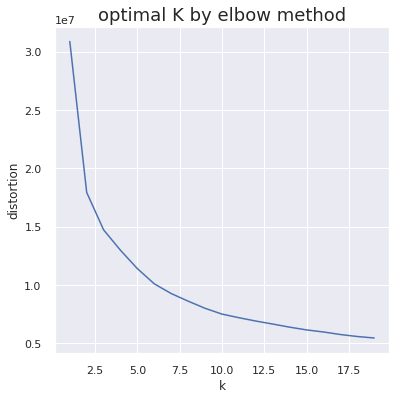

In [43]:
plt.figure(figsize=(6,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('optimal K by elbow method',fontsize= 18)
plt.show()

- fitting K-Means with best K:

In [44]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
X['cluster'] = kmeans.predict(X)

 **6. Data Scaling:**

In [45]:
Y = Y.reshape(-1,1)
S1 = PredictorScaler=StandardScaler().fit(X)
S2 = TargetVarScaler=MinMaxScaler().fit(Y)

X=S1.transform(X)
Y=S2.transform(Y)
Y = np.ravel(Y)

- splitting data into test and train:

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

**7. Best Models Selection :**

using k-fold validation technique

In [ ]:
random_forest = RandomForestRegressor(n_estimators=10)
decision_tree = DecisionTreeRegressor(max_depth=None)
svm = SVR()
KNN = KNeighborsRegressor(n_neighbors=10)
catboost = CatBoostRegressor(iterations=10, silent = True)
gbr = GradientBoostingRegressor(n_estimators=10)
etr = ExtraTreesRegressor(n_estimators=10)

models = [random_forest, decision_tree, svm, KNN, catboost, gbr, etr]

for i in models:

 lin_model_cv = cross_val_score(i, X_train, Y_train, cv= 10, scoring= 'r2')
 print(i,'average r2 score is :',lin_model_cv.mean())

RandomForestRegressor(n_estimators=10) average r2 score is : 0.5523703317110893
DecisionTreeRegressor() average r2 score is : 0.16942004485802742
SVR() average r2 score is : 0.08585168367466038
KNeighborsRegressor(n_neighbors=10) average r2 score is : 0.41290700495089433
<catboost.core.CatBoostRegressor object at 0x7f397a8289d0> average r2 score is : 0.4579146981473028
GradientBoostingRegressor(n_estimators=10) average r2 score is : 0.2473913967896003
ExtraTreesRegressor(n_estimators=10) average r2 score is : 0.6078771391148804


As shown from the previous cell execution, the top results on our data are for :
 - Random Forest Regressor.

 - CatBoost Regressor.

 - ExtraTrees Regressor.

 we will now use these three models to create an ensemble model that will make predictions depending on the participations of these models.

**8. Finding best parameters with GridSearch :**

In [ ]:
parameters = [{'n_estimators': [10, 30, 50],  
              'min_samples_split' :[2, 10, 20],
              'criterion': ['friedman_mse','squared_error']
             },
               {'iterations': [10, 30, 50]  
             },
              {'n_estimators': [10, 30, 50],  
              'min_samples_split' :[2, 10, 20]
             }]

regressors = [RandomForestRegressor(), CatBoostRegressor(silent = True), ExtraTreesRegressor()]
names = ['Random_Forest','CatBoost','Extra_Trees']

for p,r,n in zip(parameters, regressors, names):

  globals()['grid_'+ n] = GridSearchCV(r, p)

  globals()['grid_result_'+ n] = globals()['grid_'+ n].fit(X_train, Y_train)

  globals()['best_params_'+ n] = globals()['grid_result_'+ n].best_params_
  
  print( n + '', 'best parameters:',globals()['best_params_'+ n])

Random_Forest best parameters: {'criterion': 'friedman_mse', 'min_samples_split': 2, 'n_estimators': 50}
CatBoost best parameters: {'iterations': 50}
Extra_Trees best parameters: {'min_samples_split': 2, 'n_estimators': 50}


**9. Creating the Ensemble Model:**

In [47]:
def evaluate_models(models, X_train2, X_val, Y_train2, Y_val):    # this function will calculate the scores of the ensemble's models to be used 
	                                                                # as the weights of the Ensemble.
	scores = list()
	for name, model in models:
		
		model.fit(X_train2, Y_train2)
		
		Y_hat = model.predict(X_val)
		r2 = r2_score(Y_val, Y_hat)
		scores.append(r2)
		
	return scores

- Fitting the Ensemble's Models with best parameters:

In [48]:
random_forest = RandomForestRegressor(n_estimators = 50, criterion ='friedman_mse', min_samples_split = 2 )
extra_trees = ExtraTreesRegressor(n_estimators = 50, min_samples_split = 2)
CatBoost = CatBoostRegressor(50, silent= True)

models=[('CatBoost',CatBoost), ('Extra_Tree', extra_trees),('Random_Forest',random_forest)]

- training and testing data for the ensemble's models:

In [49]:
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state= 42)

- calculating scores of the ensemble's models:

In [50]:
scores = evaluate_models(models, X_train2, X_val, Y_train2, Y_val)
print(scores)

[0.6260751030365348, 0.7057465161471279, 0.6477826002703533]


- Fitting the Ensemble with models and calculated weights:

In [52]:
ensemble = VotingRegressor(estimators=models, weights= scores)

ensemble.fit(X_train, Y_train)   # fitting the ensemble with the full training data.

VotingRegressor(estimators=[('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x7fcc4ba5cd90>),
                            ('Extra_Tree',
                             ExtraTreesRegressor(n_estimators=50)),
                            ('Random_Forest',
                             RandomForestRegressor(criterion='friedman_mse',
                                                   n_estimators=50))],
                weights=[0.6260751030365348, 0.7057465161471279,
                         0.6477826002703533])

**10. Applying Evaluation Metrics on the Ensemble Model:**

- prediction results on unseen scaled data:

In [53]:
Y_pred = ensemble.predict(X_test)
print('Coefficient of determination (r2):', r2_score(Y_test, Y_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('Mean Absolute Erroe (MAE):',mean_absolute_error(Y_test, Y_pred))

Coefficient of determination (r2): 0.6703018856373888
Root Mean Square Error (RMSE): 0.040015081072931384
Mean Absolute Erroe (MAE): 0.019645160395129844


- prediction results on seen scaled data:

In [54]:
Y_pred2 = ensemble.predict(X_train)
print('Coefficient of determination (r2):', r2_score(Y_train, Y_pred2))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Y_train, Y_pred2)))
print('Mean Absolute Erroe (MAE):',mean_absolute_error(Y_train, Y_pred2))

Coefficient of determination (r2): 0.9419838852371217
Root Mean Square Error (RMSE): 0.01708606138132665
Mean Absolute Erroe (MAE): 0.008644068241322871


- Evaluating the ensemble with cross-validarion:

In [55]:
scoring = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']

scores1 = cross_validate(ensemble,X_train, Y_train, scoring = scoring)

for k,v in scores1.items():
    print(k ," : " , v)

fit_time  :  [28.1179502  29.15144563 28.36124921 28.38648772 28.18577027]
score_time  :  [0.23128748 0.22414732 0.22677732 0.22678804 0.22322154]
test_neg_mean_absolute_error  :  [-0.02008964 -0.02094843 -0.02030137 -0.02023542 -0.01964165]
test_r2  :  [0.63342905 0.63547516 0.60870635 0.64439958 0.62309839]
test_neg_root_mean_squared_error  :  [-0.04272168 -0.04438467 -0.0440324  -0.04478175 -0.0396907 ]


- visualising prediction error of normalized data:

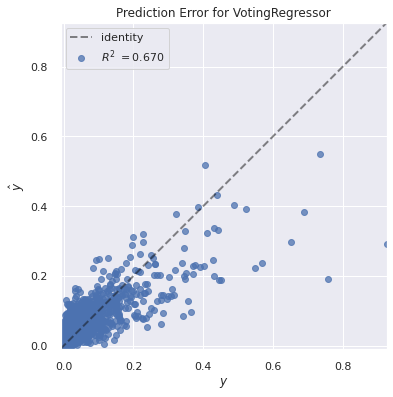

<function matplotlib.pyplot.show>

In [56]:
fig = plt.figure(figsize=(6,6))
visualizer = PredictionError(ensemble, bestfit= False)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)

visualizer.show()
plt.show  

- comparison between predictions on scaled seen data and predictions on scaled unseen data:

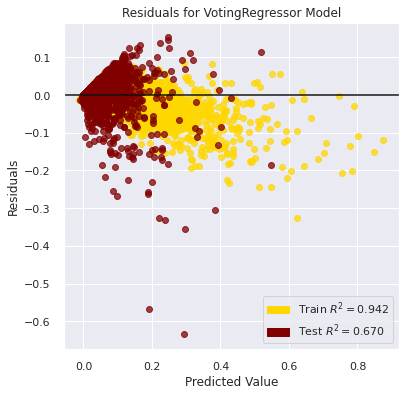

In [57]:
fig = plt.figure(figsize=(6,6))
visualizer2 = ResidualsPlot(
    ensemble, 
    hist=False, 
    train_color="gold",
    test_color="maroon"
)
visualizer2.fit(X_train, Y_train)
visualizer2.score(X_test, Y_test)
visualizer2.show()
plt.show()

- Rescaling fire areas to original values:

In [58]:
Y_pred = S2.inverse_transform(Y_pred.reshape(-1,1))
Y_test = S2.inverse_transform(Y_test.reshape(-1,1))
Y_pred2 = S2.inverse_transform(Y_pred2.reshape(-1,1))
Y_train = S2.inverse_transform(Y_train.reshape(-1,1))

- prediction results of unseen data after rescaling:

In [59]:
print('Coefficient of determination (r2):', r2_score(Y_test, Y_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('Mean Absolute Erroe (MAE):',mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(Y_test,Y_pred),'%')
print('Total Accuracy:', round((100 - np.mean(mean_absolute_percentage_error(Y_test,Y_pred))), 3), '%')

Coefficient of determination (r2): 0.6703018856373888
Root Mean Square Error (RMSE): 158.24994746834955
Mean Absolute Erroe (MAE): 77.69184810272968
Mean Absolute Percentage Error: 3.296814132423618 %
Total Accuracy: 96.703 %


- prediction results of seen data after rescaling:

In [60]:
print('Coefficient of determination (r2):', r2_score(Y_train, Y_pred2))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Y_train, Y_pred2)))
print('Mean Absolute Erroe (MAE):',mean_absolute_error(Y_train, Y_pred2))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(Y_train, Y_pred2),'%')
print('Total Accuracy:', round((100 - np.mean(mean_absolute_percentage_error(Y_train, Y_pred2))), 3), '%')

Coefficient of determination (r2): 0.9419838852371217
Root Mean Square Error (RMSE): 67.57123173405235
Mean Absolute Erroe (MAE): 34.18519489212078
Mean Absolute Percentage Error: 1.56613591246869 %
Total Accuracy: 98.434 %


**11. Plotting the results:**

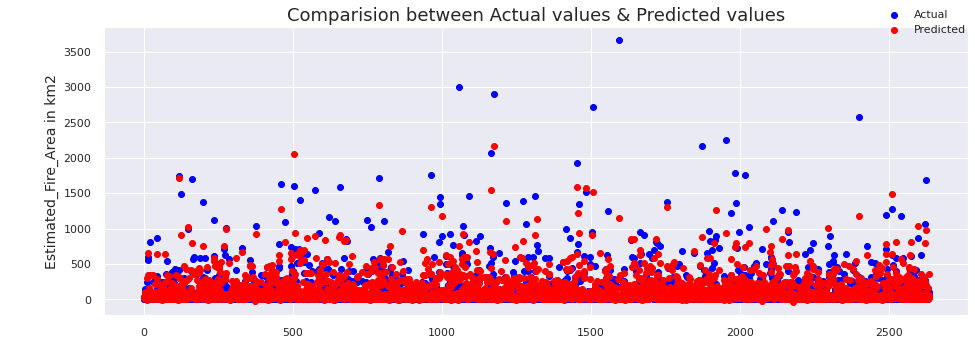

In [61]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_axes([1,1,2,1])
plt.scatter(range(len(Y_test)),Y_test, color='blue')
plt.scatter(range(len(Y_test)),Y_pred, color='red')
plt.title('Comparision between Actual values & Predicted values', fontsize = 18)
fig.legend(labels = ('Actual','Predicted'),loc='upper right')
axes.set_ylabel('Estimated_Fire_Area in km2',fontsize = 14)
plt.show()